##### Lecture 17: Partial Differential Equations - Elliptic

1. Steady-State 2D temperature of a plate

$$\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0$$

Constant (Dirichlet) BCs are: $B_l=75$, $B_u=100$, $B_r=50$, $B_d=0$. Units are Celsius.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

In [2]:
n = 50 # grid size (n^2 internal nodes)

# LHS matrix A (bandwidth = 2n+1). Make diagonals separately:
main = 4*np.ones(n**2)
off1 = -1*np.ones(n**2-1)
off1[n-1:-1:n] = 0 # account for zeros on +/-1 diagonal
offn = -1*np.ones(n**2-n) # the +/- nth diagonal contains n^2-n elements
A = np.diag(main) + np.diag(off1,1) + np.diag(off1,-1) + np.diag(offn,n) + np.diag(offn,-n)

if n <= 3:
    print(A) # confirm same as lecture notes, do not print for larger n

Next create the right-hand side vector $\mathbf{b}$, which contains the boundary conditions. There are two ways to do this: (1) create a $n^2 \times 1$ vector and assign the index values from the lecture notes, or (2) create a $n \times n$ matrix, assign the boundaries, and then reshape to $n^2 \times 1$. This is option (2).

In [3]:
# Create RHS vector b with boundary conditions
Bd,Bl,Br,Bu = (0,75,50,100)

b = np.zeros((n,n))
b[:,0] += Bl
b[:,-1] += Br
b[0,:] += Bd
b[-1,:] += Bu
b = np.reshape(b, (n**2,1))

if n <= 3:
    print(b)

Solve with built-in `np.linalg.solve`. Note $\mathbf{A}$ is sparse, so for large values of $n$ it may be more efficient to use an iterative method such as Gauss-Seidel.

In [4]:
T = np.linalg.solve(A,b) # returns n^2 x 1 column vector
T = np.reshape(T,(n,n))

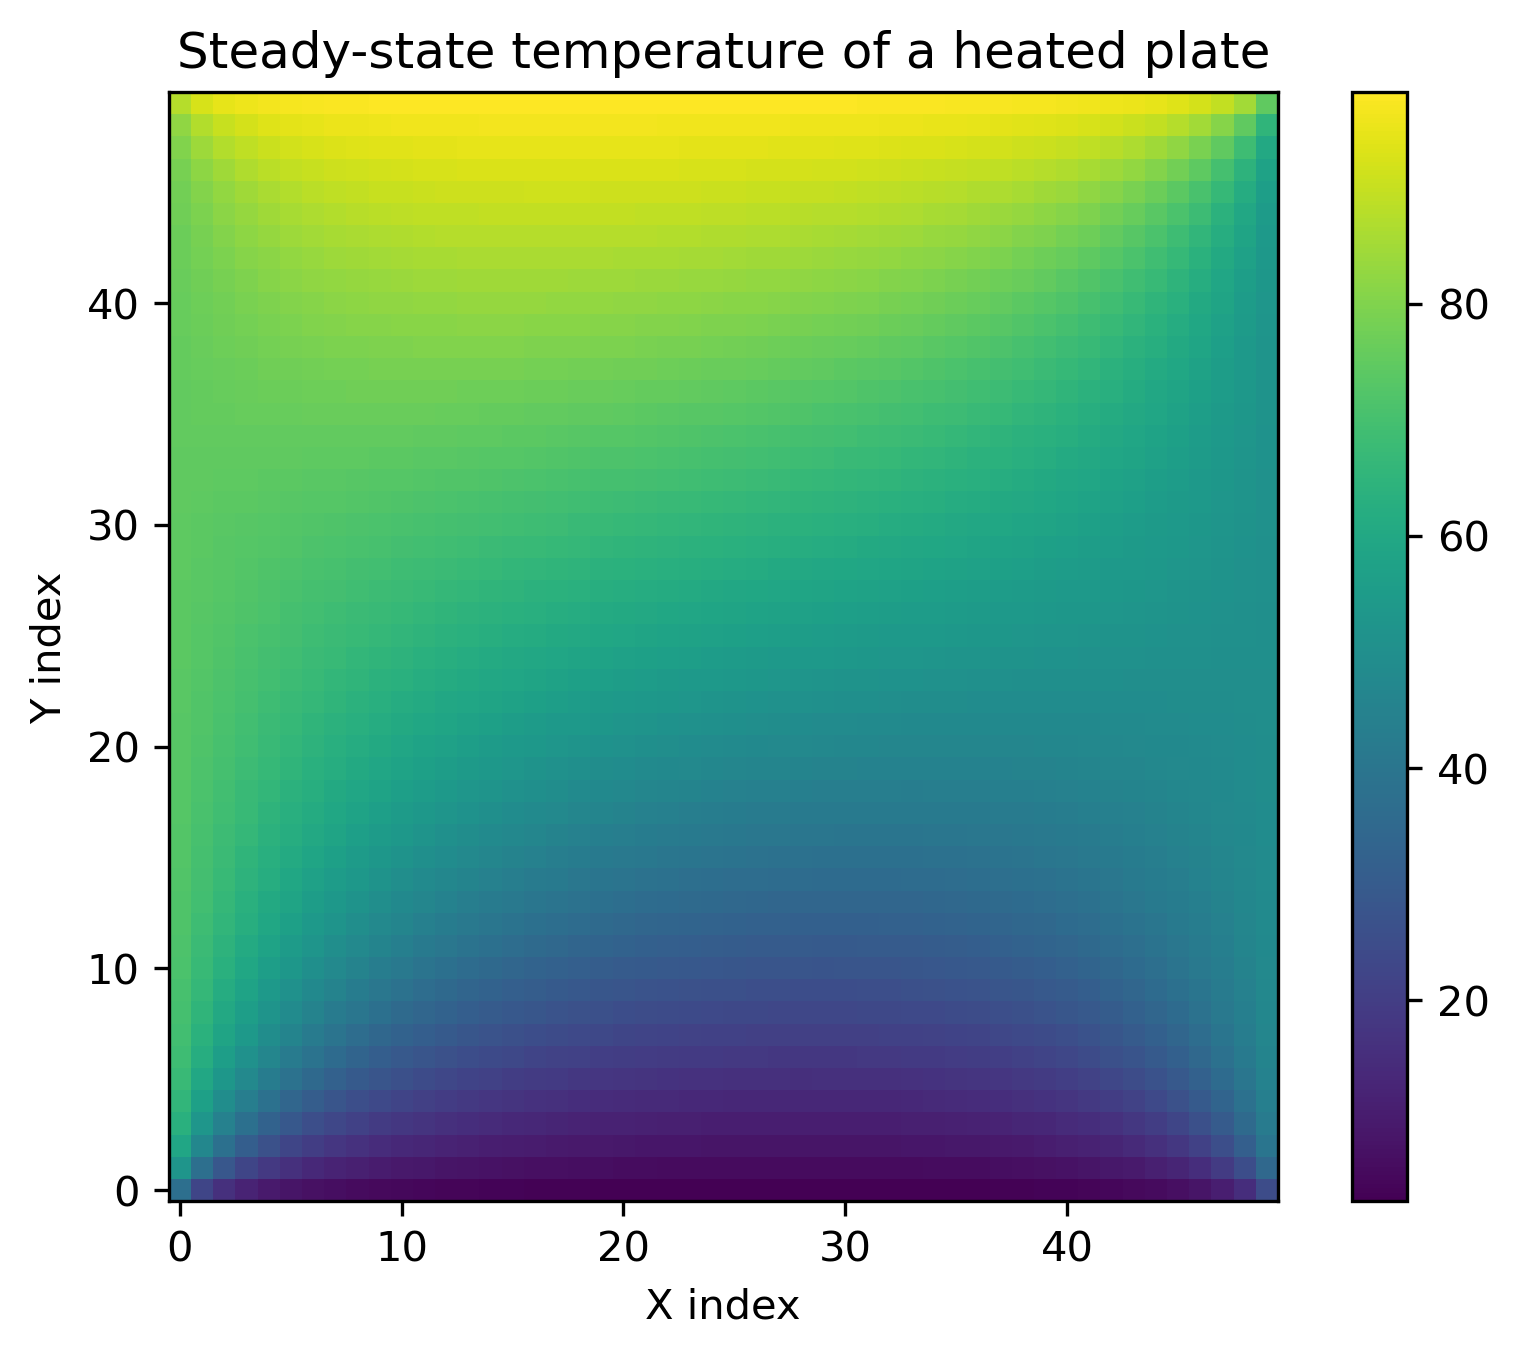

In [5]:
plt.imshow(T, origin='lower') # default puts origin at top-left
plt.colorbar()
plt.title('Steady-state temperature of a heated plate')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.show()

--------------
##### Point Source
2. Add point source $=75$ in the center of the grid. We only need to modify `b`, not `A`. The center of the grid occurs at index `n^2/2 + n/2`.

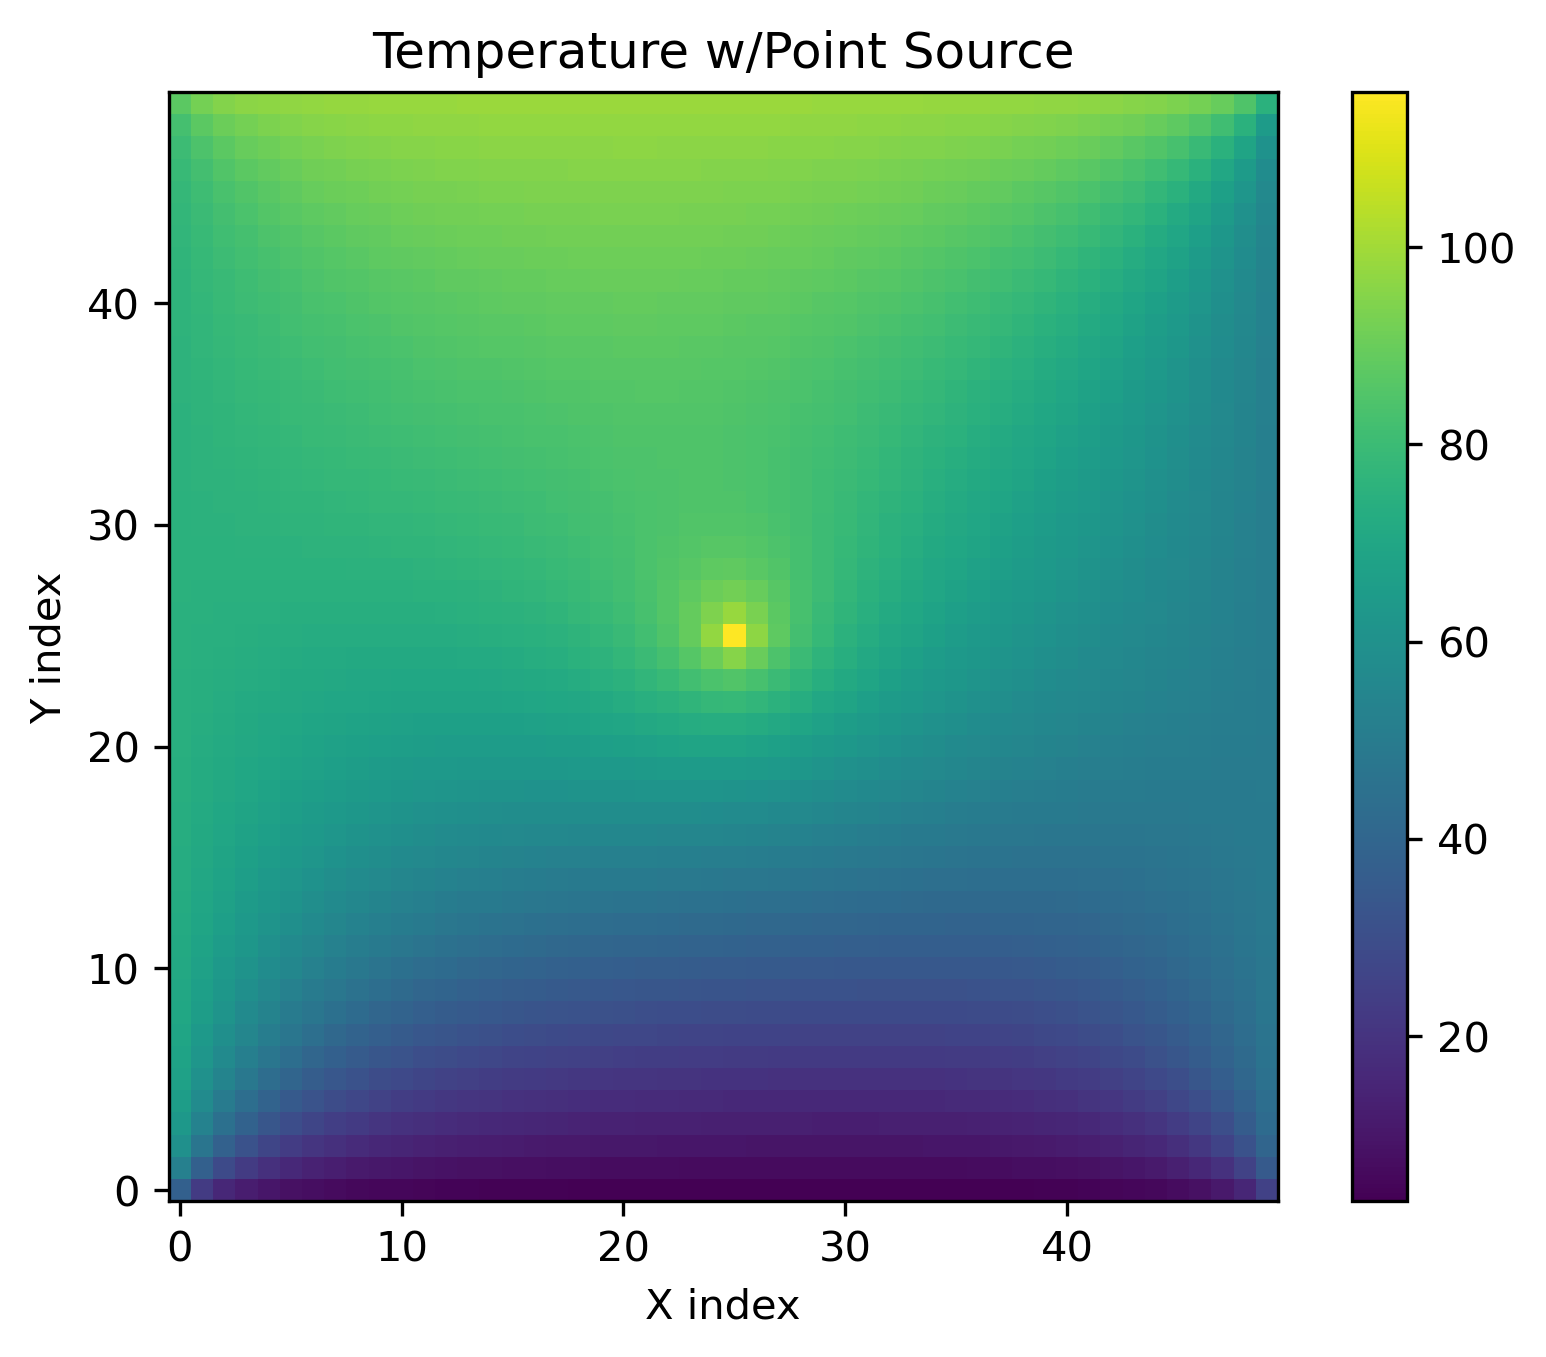

In [6]:
b2 = b.copy()
b2[int(n**2/2 + n/2)] += 75
T = np.linalg.solve(A,b2)
T = np.reshape(T,(n,n))

plt.imshow(T, origin='lower')
plt.colorbar()
plt.title('Temperature w/Point Source')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.show()

---------------
##### Neumann BC
3. Repeat with the lower boundary condition changed to no-flux, $\frac{\partial T}{\partial y}=0$.

In [7]:
# clear all variables
%reset -f 

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

n = 50 # grid size (n^2 internal nodes)
d = n**2 + n # dimension of unknowns

# LHS matrix A
main = 4*np.ones(d)
off1 = -1*np.ones(d-1)
off1[n-1:-1:n] = 0 # account for zeros on +/-1 diagonal
offnup = -1*np.ones(d-n) # the +/- nth diagonal contains d-n elements
offndown = -1*np.ones(d-n)
# First n rows: the +nth diagonal is -2 to enforce the lower BC
offnup[:n] = -2

A = np.diag(main) + np.diag(off1,1) + np.diag(off1,-1) + np.diag(offnup,n) + np.diag(offndown,-n)

# RHS BCs (note no Bd anymore)
Bl,Br,Bu = (75,50,100)
b = np.zeros((n+1,n)) # now n+1 rows
b[:,0] += Bl
b[:,-1] += Br
b[-1,:] += Bu
b = np.reshape(b, (d,1))

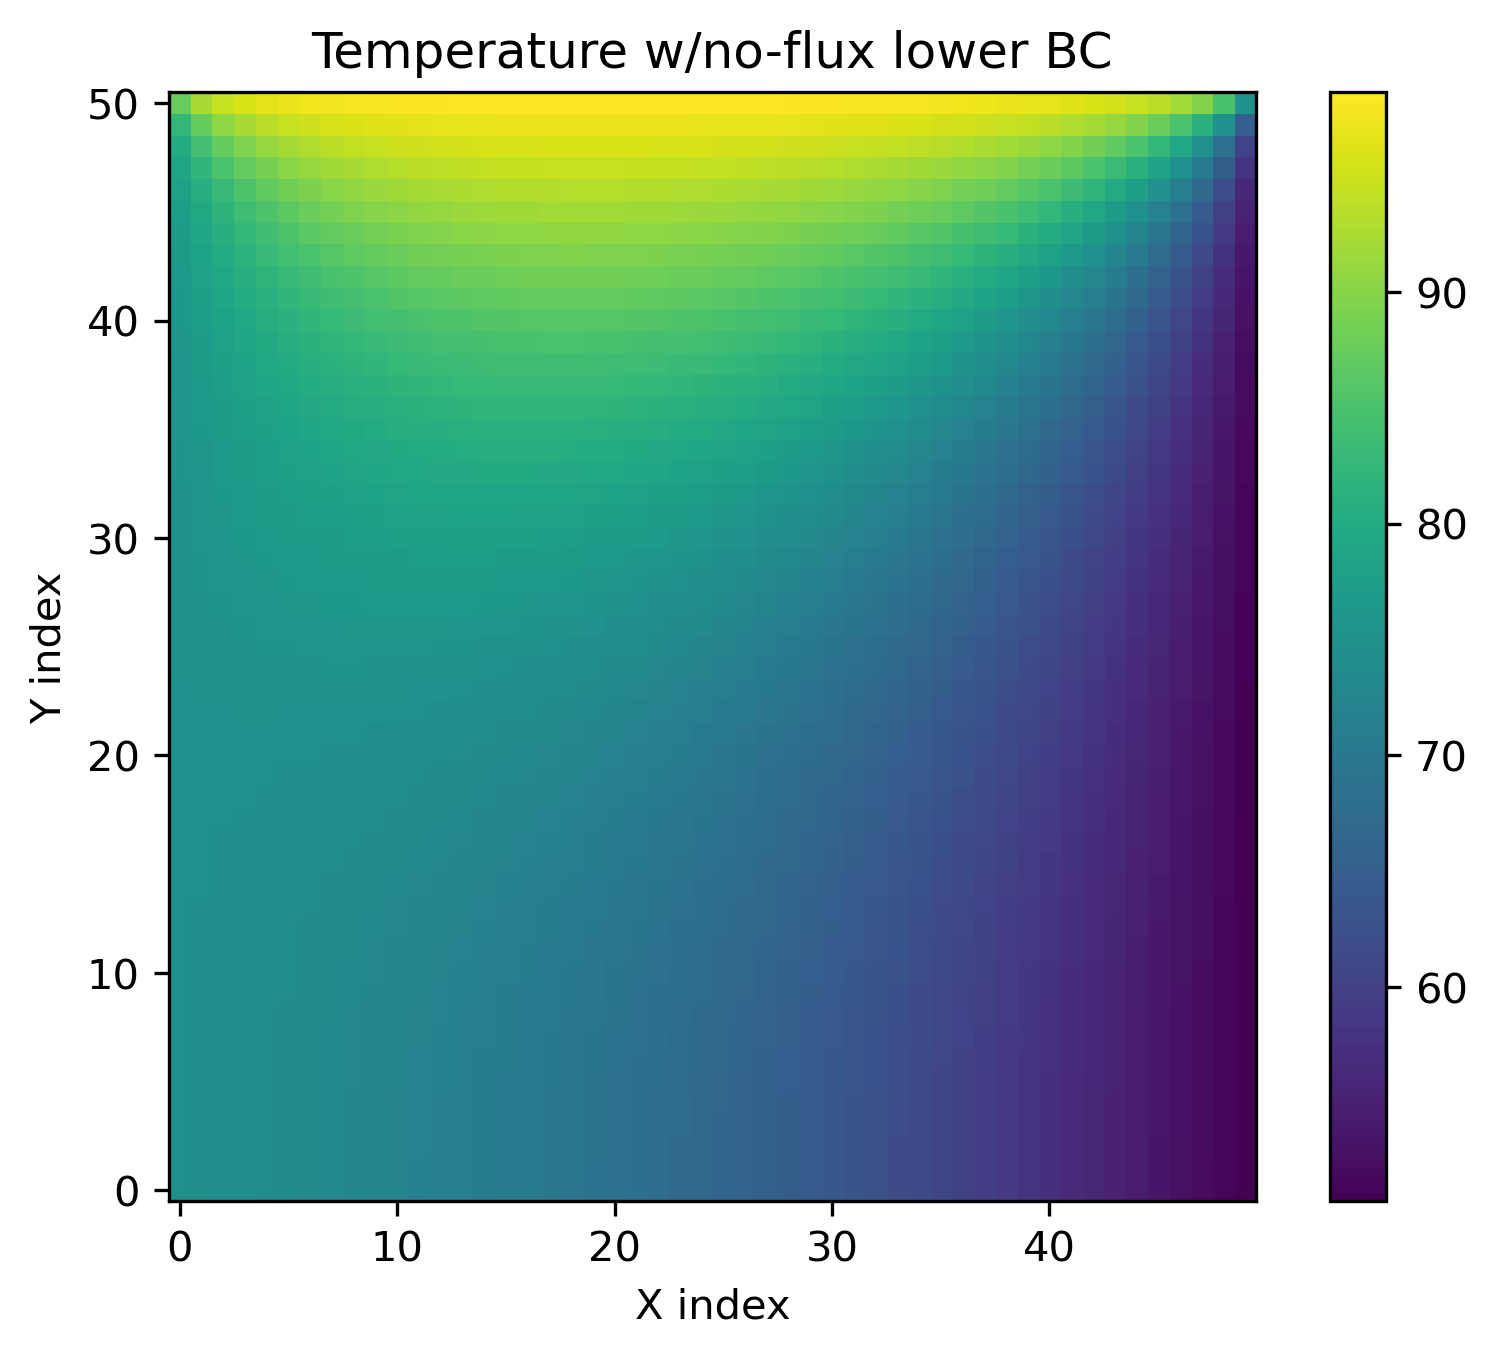

In [8]:
T = np.linalg.solve(A,b)
T = np.reshape(T,(n+1,n))
plt.imshow(T, origin='lower')
plt.colorbar()
plt.title('Temperature w/no-flux lower BC')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.show()

In all of these cases, our plots only show the internal nodes where we are solving for $T$. We could also append the BCs around the edge of the grid.

---------------
#### Iterative solution
Gauss-Seidel iteration (Liebmann's method)
Good for large $n$ and irregular geometries, such as HW 8 Problem 32.4

1105  iterations


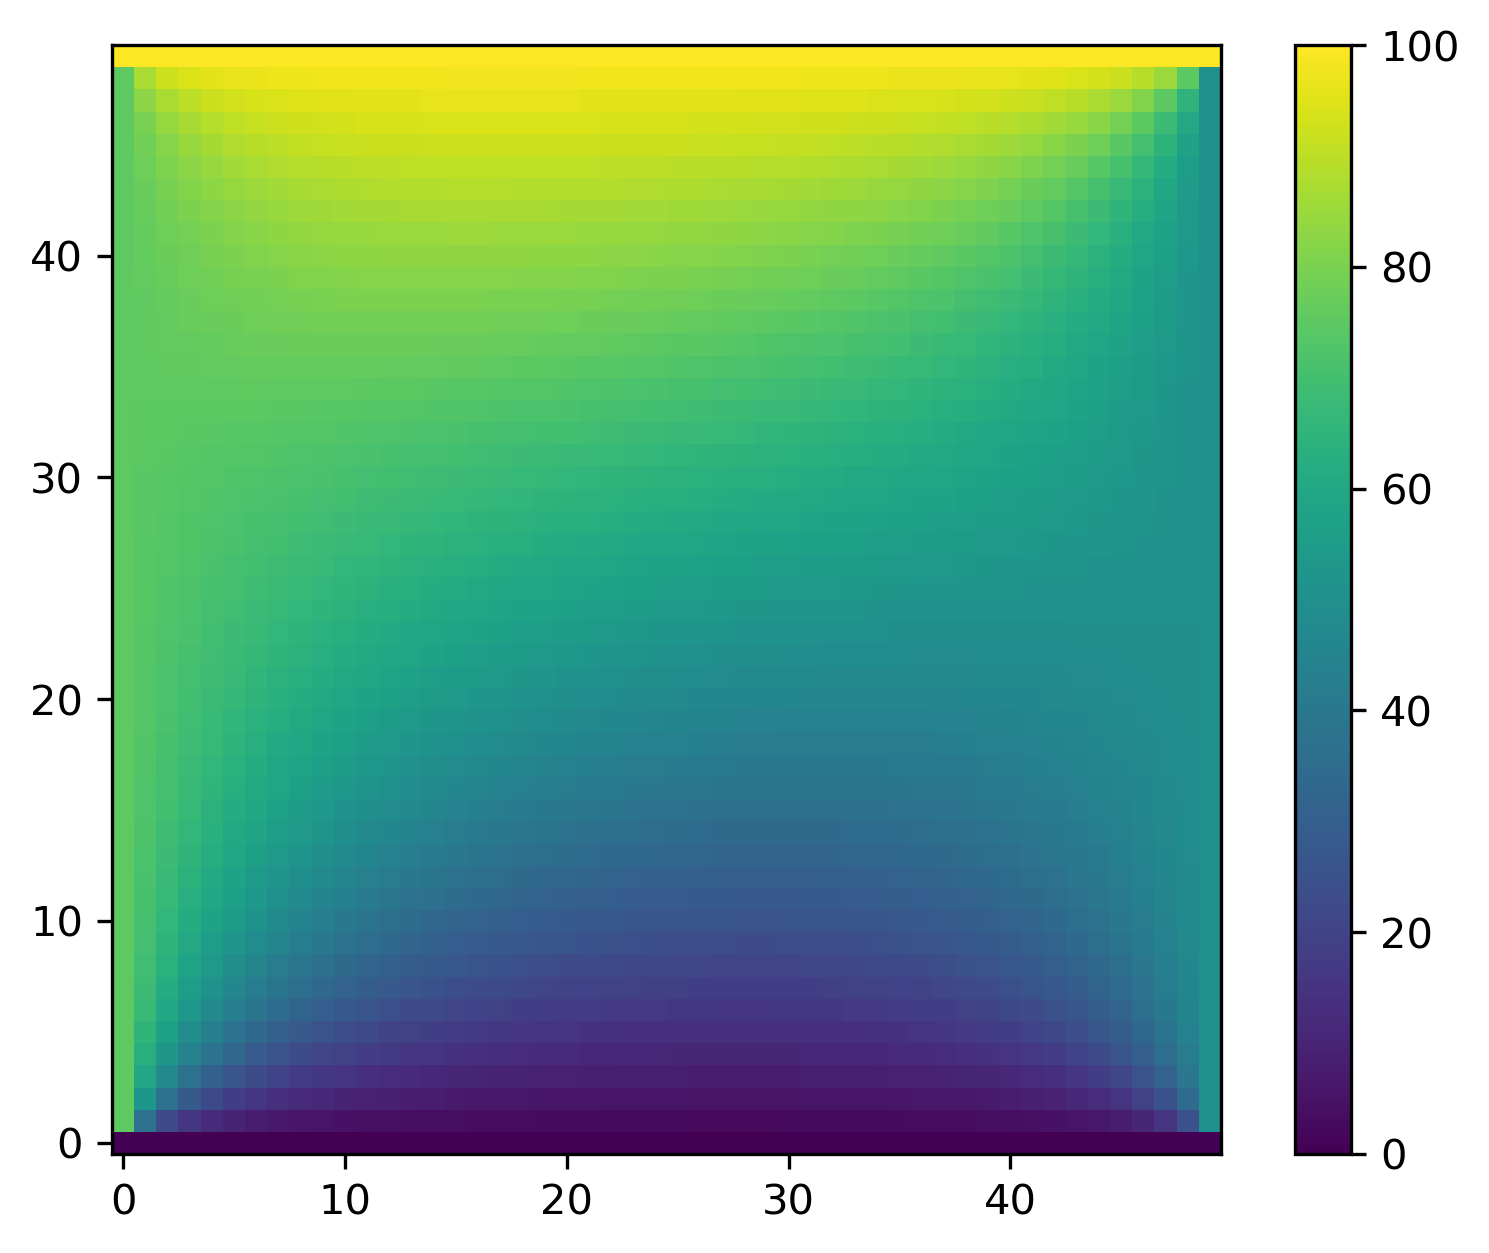

In [9]:
# start from scratch with Dirichlet BC problem
import scipy.linalg as sl

Bd,Bl,Br,Bu = (0,75,50,100)
n = 50
err = 9999
it = 0 # iteration count
T = np.zeros((n,n))

while err > 1e-1:
  T_old = T.copy() # store to calculate error
  for i in range(1,n-1): # exclude BCs
    for j in range(1,n-1):
      T[i,j] = (T[i+1,j] + T[i-1,j] + T[i,j+1] + T[i,j-1]) / 4
  
  T[:,0] = Bl # BCs around edge
  T[:,-1] = Br
  T[0,:] = Bd
  T[-1,:] = Bu
  # for Neumann no-flux BCs, set T[0,:] = T[1,:] instead
    
  err = sl.norm(T - T_old, 2)
  it += 1

print(it, ' iterations')
plt.imshow(T, origin='lower')
plt.colorbar()
plt.show()

---------------
##### Other types of plots

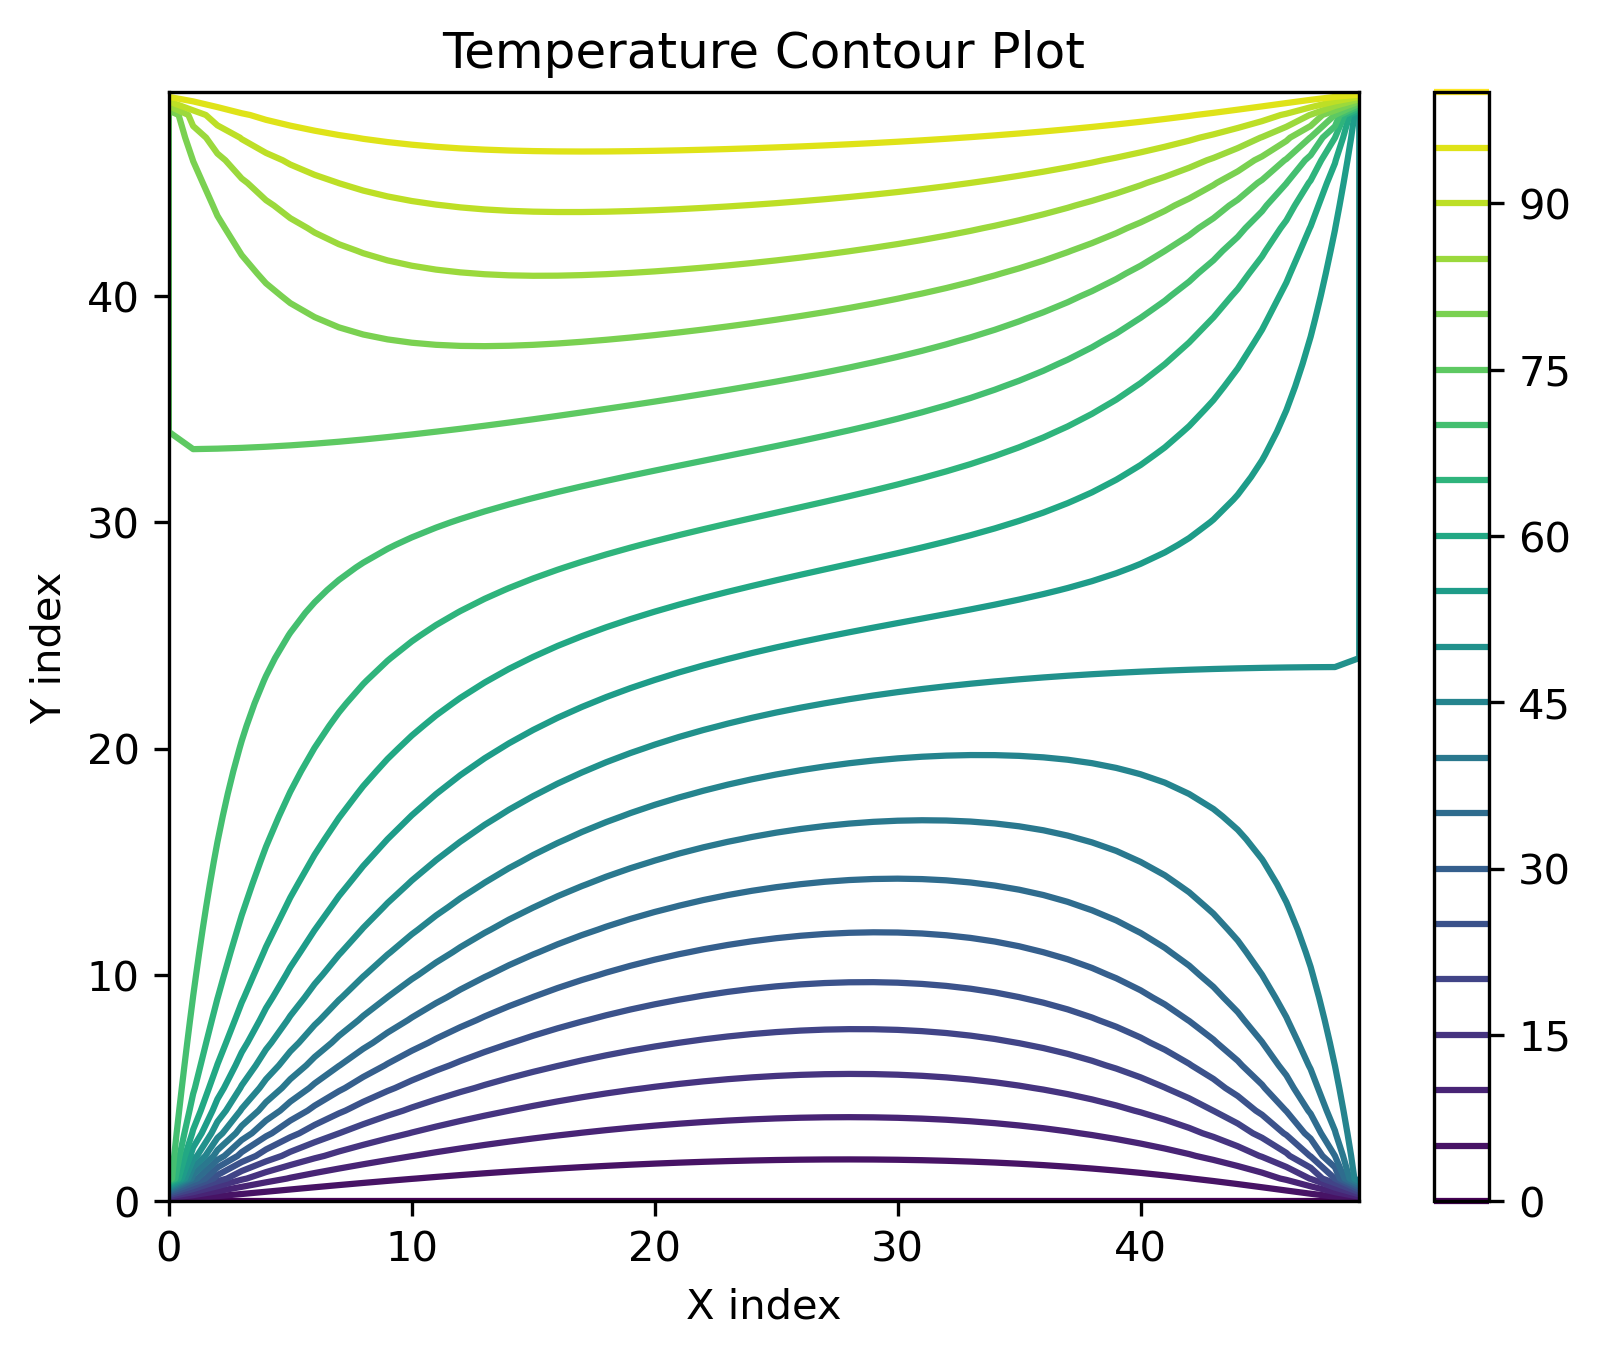

In [10]:
plt.contour(T, levels=20)
plt.title('Temperature Contour Plot')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.colorbar()
plt.show()

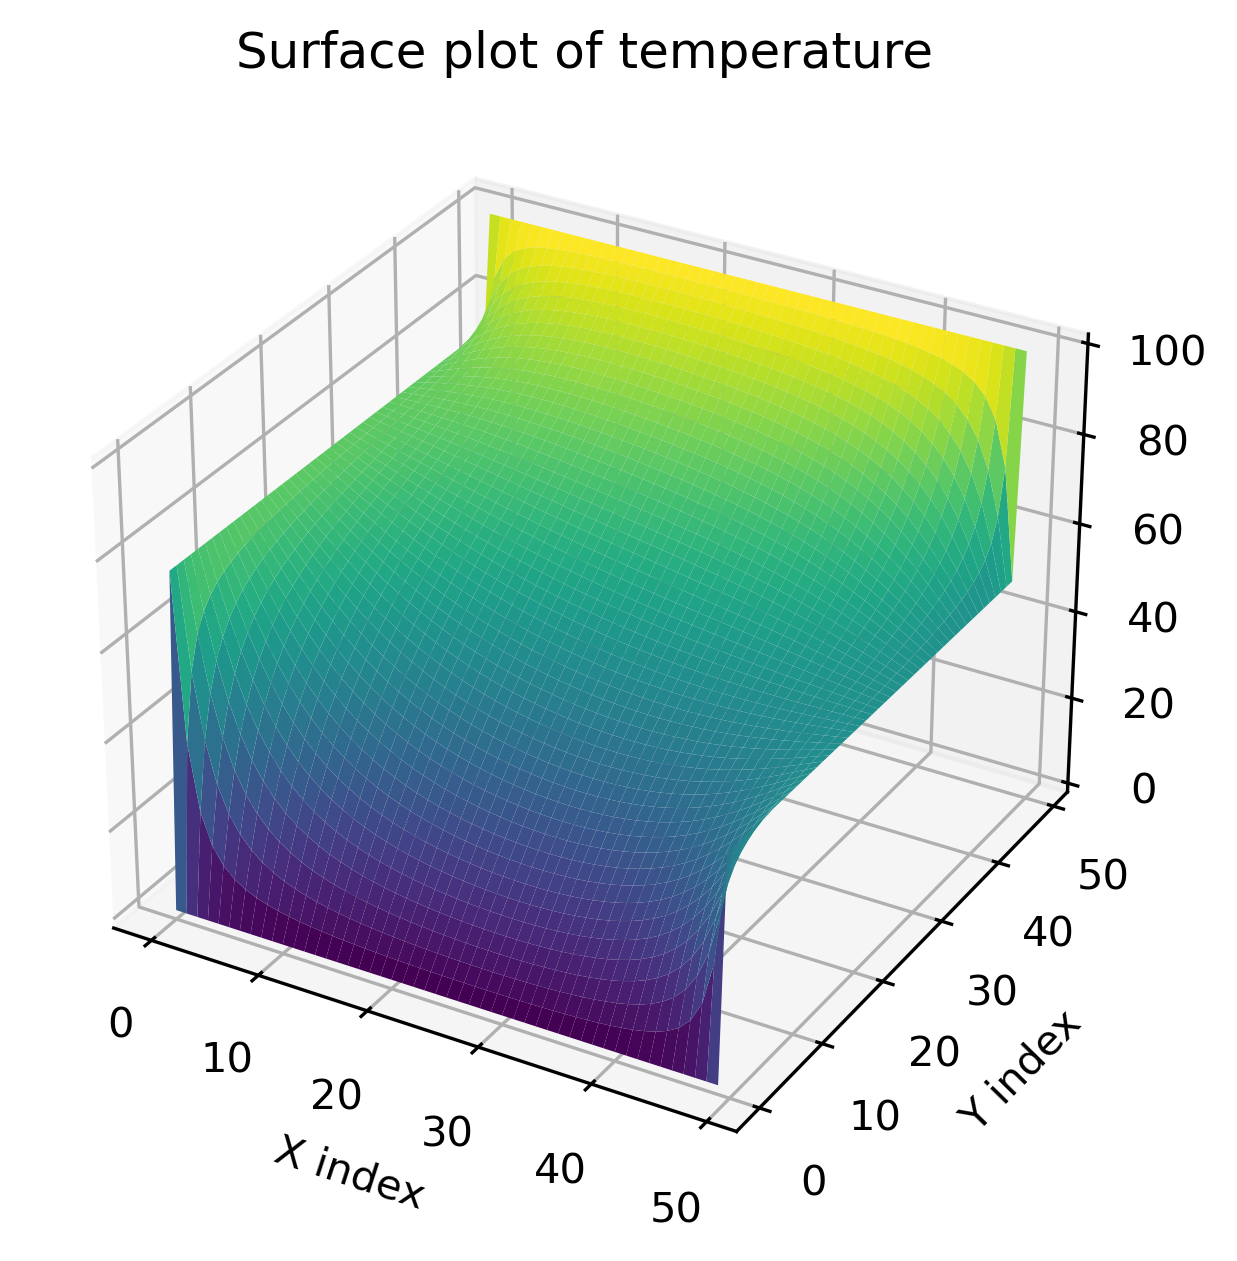

In [11]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = np.arange(0,n)
Y = np.arange(0,n)
X, Y = np.meshgrid(X, Y) # creates a 2D grid from 1D vectors
ax.plot_surface(X, Y, T, cmap='viridis')
plt.title('Surface plot of temperature')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.show()
